In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# To display float with 2 decimal, avoid scientific printing
pd.options.display.float_format = '{:.3f}'.format
import seaborn as sns
sns.set()
pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)

In [2]:
df = pd.read_csv('./Data/Final_invoice.csv')

In [3]:
df.shape

(492314, 59)

In [4]:
df.isnull().sum()

Unnamed: 0                   0
Amt Rcvd From Custom    197286
Amt Rcvd From Ins Co    197286
Area / Locality          23890
CGST(14%)               197286
CGST(2.5%)              197286
CGST(6%)                197286
CGST(9%)                197286
CITY                         1
Cash /Cashless Type     464894
Claim No.               487510
Cust Type                    0
Customer No.                 0
District                     0
Expiry Date             470083
Gate Pass Date          451399
Gate Pass Time               0
IGST(12%)               197286
IGST(18%)               197286
IGST(28%)               197286
IGST(5%)                197286
Insurance Company       468723
Invoice Date                 0
Invoice No                   0
Invoice Time                 0
Job Card No                  0
JobCard Date                 0
JobCard Time                 0
KMs Reading                  0
Labour Total                 0
Make                         0
Misc Total                   0
Model   

In [5]:
columns_to_be_removed = df.isnull().sum()[df.isnull().sum().sort_values() > 197285].index

In [6]:
invoice = df.drop(columns=columns_to_be_removed)

In [7]:
country_cust_data=invoice[['Cust Type','Customer No.']].drop_duplicates()
country_cust_data.groupby(['Cust Type'])['Customer No.'].aggregate('count').reset_index().sort_values('Customer No.', ascending=False)

,Cust Type,Customer No.
6,Retail,253450
0,Corporate others,48
2,Fleets,20
1,Corporate- M&M,15
3,Franchise,6
5,MFCWL,2
4,Insurance,1


In [8]:
Rtl_data = invoice[invoice['Cust Type'] == 'Retail'].reset_index(drop=True)

In [9]:
Rtl_data['Total Amt Wtd Tax.'].min()

-137.0

In [10]:
#Filter out records with negative values
Rtl_data = Rtl_data[(Rtl_data['Total Amt Wtd Tax.']>0)]

In [11]:
#Convert the string date field to datetime
Rtl_data['Invoice Date'] = pd.to_datetime(Rtl_data['Invoice Date'])

In [12]:
print('Min:{}; Max:{}'.format(min(Rtl_data['Invoice Date']),
max(Rtl_data['Invoice Date'])))

Min:2012-04-02 00:00:00; Max:2016-10-31 00:00:00


In [13]:
import datetime as dt

In [14]:
snapshot_date = max(Rtl_data['Invoice Date']) + dt.timedelta(days=1)

In [15]:
snapshot_date

Timestamp('2016-11-01 00:00:00')

In [16]:
# Aggregate data on a customer level
datamart = Rtl_data.groupby(['Customer No.']).agg({
'Invoice Date': lambda x: (snapshot_date - x.max()).days,
'Invoice No': 'count',
'Total Amt Wtd Tax.': 'sum'})
# Rename columns for easier interpretation
datamart.rename(columns = {'Invoice Date': 'Recency',
'Invoice No': 'Frequency',
'Total Amt Wtd Tax.': 'MonetaryValue'}, inplace=True)

datamart['Tenure'] = Rtl_data.groupby(['Customer No.']).agg({'Invoice Date': lambda x: ((x.max() - x.min())+dt.timedelta(days=1)).days})
# Check the first rows
datamart.head(30)

,Recency,Frequency,MonetaryValue,Tenure
Customer No.,,,,
10,1233,5,11105.560,440
100,1511,2,20799.740,157
1000,749,6,8813.440,884
10000,437,4,1735.520,662
100000,563,1,6026.050,1
100001,351,3,4263.750,211
100004,563,1,249.220,1
100005,563,1,2274.840,1
100006,561,1,1223.710,1


In [19]:
datamart.reset_index()

,Customer No.,Recency,Frequency,MonetaryValue,Tenure
0,10,1233,5,11105.560,440
1,100,1511,2,20799.740,157
2,1000,749,6,8813.440,884
3,10000,437,4,1735.520,662
4,100000,563,1,6026.050,1
...,...,...,...,...,...
239936,PLX048,1,1,8860.870,1
239937,PLX109,28,1,842.930,1
239938,PLX277,6,1,6870.950,1
239939,PLX312,84,1,567.800,1


In [20]:
datamart.Tenure.describe()

count   239941.000
mean        89.532
std        202.757
min          1.000
25%          1.000
50%          1.000
75%         65.000
max       1644.000
Name: Tenure, dtype: float64

In [146]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(datamart['Recency'], 4, labels = r_labels)
datamart = datamart.assign(R = r_quartiles.values)

In [147]:
datamart.head()

,Recency,Frequency,MonetaryValue,Tenure,R
Customer No.,,,,,
10,1233,5,11105.560,440,1
100,1511,2,20799.740,157,1
1000,749,6,8813.440,884,1
10000,437,4,1735.520,662,2
100000,563,1,6026.050,1,2


In [149]:
#t_labels = range(1,5)
m_labels = range(1,5)
#t_quartiles = pd.qcut(datamart['Tenure'], 4, labels = t_labels)
m_quartiles = pd.qcut(datamart['MonetaryValue'], 4, labels = m_labels)
#datamart = datamart.assign(T = t_quartiles.values)
datamart = datamart.assign(M = m_quartiles.values)

In [150]:
#Split into four segments using quantiles
quantiles = datamart.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

def FScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
datamart['F'] = datamart['Frequency'].apply(FScoring, args=('Frequency',quantiles,)) 
datamart['T'] = datamart['Tenure'].apply(FScoring, args=('Tenure',quantiles,))

In [157]:
datamart['T'].value_counts()

1    158864
4     59866
3     21211
Name: T, dtype: int64

In [159]:
def join_rfm(x): return str(x['R']) + str(x['M']) + str(x['F']) + str(x['T'])
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)
datamart['RFM_Score'] = datamart[['R','M','F','T']].sum(axis=1)

In [160]:
datamart

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Segment,RFM_Score
Customer No.,,,,,,,,,,
10,1233,5,11105.560,440,1,4,4,4,1444,13.000
100,1511,2,20799.740,157,1,4,3,4,1434,12.000
1000,749,6,8813.440,884,1,4,4,4,1444,13.000
10000,437,4,1735.520,662,2,2,4,4,2244,12.000
100000,563,1,6026.050,1,2,3,1,1,2311,7.000
...,...,...,...,...,...,...,...,...,...,...
PLX048,1,1,8860.870,1,4,4,1,1,4411,10.000
PLX109,28,1,842.930,1,4,2,1,1,4211,8.000
PLX277,6,1,6870.950,1,4,3,1,1,4311,9.000


In [161]:
datamart.RFM_Segment.value_counts()

3111    15330
4111    14457
1211    14343
2111    12815
1111    12184
        ...  
2441        7
4441        6
2141        4
2241        4
2341        3
Name: RFM_Segment, Length: 111, dtype: int64

### apne paas top 10 sized customers mei sirf ek premium  customer hai jiska score 7 hai 

In [162]:
datamart.groupby(['RFM_Segment','RFM_Score']).size().sort_values(ascending=False).tail(30)

RFM_Segment  RFM_Score
4231         10.000       154
3144         12.000       146
4131         9.000        134
3243         12.000       128
2231         8.000         93
2243         11.000        88
1243         10.000        75
4143         12.000        73
2144         11.000        65
3141         9.000         55
3143         11.000        47
2131         7.000         39
1341         9.000         38
3241         10.000        35
1144         10.000        35
1131         6.000         24
2143         10.000        23
1441         10.000        21
1143         9.000         19
3341         11.000        18
3441         12.000        16
1241         8.000         15
4241         11.000        13
4141         10.000        10
4341         12.000        10
2441         11.000         7
4441         13.000         6
2141         8.000          4
2241         9.000          4
2341         10.000         3
dtype: int64

In [163]:
datamart['RFM_Score'].value_counts()

7.000     37964
6.000     36228
5.000     27158
8.000     25310
13.000    17626
14.000    16574
9.000     15406
12.000    14159
4.000     12184
15.000    10774
11.000    10369
10.000     9953
16.000     6236
Name: RFM_Score, dtype: int64

### mere best customers (12) wale 7040 hai aur worst customers (3) wale 12184 hai we mostly have medium scored customers

In [164]:
datamart[datamart['RFM_Segment']=='1111'][:30]

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Segment,RFM_Score
Customer No.,,,,,,,,,,
10007,1360,1,209.640,1,1,1,1,1,1111,4.000
10010,1359,1,399.560,1,1,1,1,1,1111,4.000
10020,1359,1,200.280,1,1,1,1,1,1111,4.000
10029,1360,1,598.960,1,1,1,1,1,1111,4.000
10033,1360,1,148.600,1,1,1,1,1,1111,4.000
10038,1359,1,599.900,1,1,1,1,1,1111,4.000
10059,1359,1,449.500,1,1,1,1,1,1111,4.000
1007,1635,1,598.960,1,1,1,1,1,1111,4.000
10081,1359,1,599.900,1,1,1,1,1,1111,4.000


### ye lautke naa aanewale customer hai bc

In [165]:
datamart[datamart['RFM_Segment']=='4444'].sort_values(by = 'MonetaryValue',ascending = False)

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Segment,RFM_Score
Customer No.,,,,,,,,,,
E4981,60,1086,4813755.940,1614,4,4,4,4,4444,16.000
412,81,605,3801248.910,1578,4,4,4,4,4444,16.000
164806,1,20,2030874.120,236,4,4,4,4,4444,16.000
MFCCM14,9,108,1871438.670,1606,4,4,4,4,4444,16.000
E11206,12,576,1392232.880,745,4,4,4,4,4444,16.000
...,...,...,...,...,...,...,...,...,...,...
192648,74,5,8807.770,81,4,4,4,4,4444,16.000
188860,41,3,8806.430,114,4,4,4,4,4444,16.000
122818,12,4,8805.810,419,4,4,4,4,4444,16.000


### ye best customers hai

In [166]:
datamart.groupby('RFM_Score').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count'] ,
'Tenure':'mean'}).round(1)

Recency Frequency MonetaryValue         Tenure
              mean      mean          mean  count    mean
RFM_Score                                                
4.000     1054.200     1.000       320.300  12184   1.000
5.000      786.300     1.000       977.200  27158   1.000
6.000      508.600     1.000      1938.400  36228   1.000
7.000      303.600     1.000      4108.100  37964   1.000
8.000      218.700     1.000      7532.400  25310   1.300
9.000      213.600     1.200     10663.700  15406   5.800
10.000     420.200     1.600     12785.400   9953  50.700
11.000     627.200     2.100      6962.900  10369 130.900
12.000     494.400     2.400     10252.500  14159 170.800
13.000     451.300     3.200     16465.100  17626 246.600
14.000     268.900     3.800     22061.300  16574 338.100
15.000     128.900     4.700     27042.600  10774 404.200
16.000      45.900     6.100     38396.600   6236 426.700

In [90]:
datamart

,Recency,Frequency,MonetaryValue,R,M,F,RFM_Segment,RFM_Score
Customer No.,,,,,,,,
10,1233,5,11105.560,1,4,4,144,9.000
100,1511,2,20799.740,1,4,3,143,8.000
1000,749,6,8813.440,1,4,4,144,9.000
10000,437,4,1735.520,2,2,4,224,8.000
100000,563,1,6026.050,2,3,1,231,6.000
...,...,...,...,...,...,...,...,...
PLX048,1,1,8860.870,4,4,1,441,9.000
PLX109,28,1,842.930,4,2,1,421,7.000
PLX277,6,1,6870.950,4,3,1,431,8.000


In [167]:
def segment_me(df):
    if df['RFM_Score'] > 14:
        return 'Platinum'
    elif (df['RFM_Score'] > 12) and (df['RFM_Score'] < 15):
        return 'Gold'
    elif (df['RFM_Score'] > 10) and (df['RFM_Score'] < 13):
        return 'Silver'
    elif (df['RFM_Score'] > 8) and (df['RFM_Score'] < 11):
        return 'Bronze'
    else:
        return '1 time customers'
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count'],
'Tenure':'mean'}).round(1)

Recency Frequency MonetaryValue          Tenure
                    mean      mean          mean   count    mean
General_Segment                                                 
1 time customers 501.900     1.000      3221.400  138844   1.100
Bronze           294.700     1.300     11496.500   25359  23.400
Gold             362.900     3.500     19177.100   34200 290.900
Platinum          98.500     5.200     31205.100   17010 412.500
Silver           550.500     2.300      8861.800   24528 154.000

In [169]:
datamart.head()

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Segment,RFM_Score,General_Segment
Customer No.,,,,,,,,,,,
10,1233,5,11105.560,440,1,4,4,4,1444,13.000,Gold
100,1511,2,20799.740,157,1,4,3,4,1434,12.000,Silver
1000,749,6,8813.440,884,1,4,4,4,1444,13.000,Gold
10000,437,4,1735.520,662,2,2,4,4,2244,12.000,Silver
100000,563,1,6026.050,1,2,3,1,1,2311,7.000,1 time customers


In [199]:
datamart['General_Segment'].value_counts()

1 time customers    138844
Gold                 34200
Bronze               25359
Silver               24528
Platinum             17010
Name: General_Segment, dtype: int64

In [170]:
datamart['R'] = datamart['R'].astype(int)
datamart['M'] = datamart['M'].astype(int)


In [171]:
datamart.describe()

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Score
count,239941.000,239941.000,239941.000,239941.000,239941.000,239941.000,239941.000,239941.000,239941.000
mean,436.550,1.821,8930.659,89.532,2.502,2.500,1.886,1.925,8.814
std,404.348,3.544,24918.783,202.757,1.120,1.118,1.227,1.320,3.418
min,1.000,1.000,0.010,1.000,1.000,1.000,1.000,1.000,4.000
25%,102.000,1.000,697.370,1.000,2.000,1.000,1.000,1.000,6.000
50%,291.000,1.000,2910.000,1.000,3.000,2.000,1.000,1.000,8.000
75%,702.000,2.000,8793.840,65.000,4.000,3.000,3.000,3.000,12.000
max,1674.000,1086.000,4813755.940,1644.000,4.000,4.000,4.000,4.000,16.000


In [172]:
#Descriptive Statistics (Recency)
datamart.Recency.describe()

count   239941.000
mean       436.550
std        404.348
min          1.000
25%        102.000
50%        291.000
75%        702.000
max       1674.000
Name: Recency, dtype: float64

recency insights
min ek din purana customer hai.....max 1674 din purana hai...............on an avg recency kharab hai kyuki 428 din baaad customer aaraa...std deviation bhi bahot zyada soln: recency badhane k liye customer care support improve karo....where in regular calls are made to the oldest customers to newest....reminding dem of serice done previously.........defaults from the last serivice.......recommendation for new service..........any ongoin discount promotion(free inspection prog)... if he comes again for service.....[ola uber]

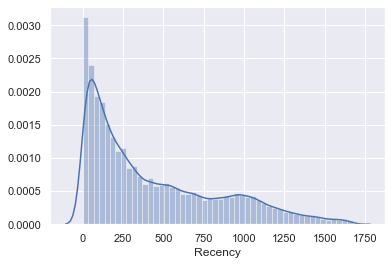

In [173]:
#Recency distribution plot
import seaborn as sns
x = datamart['Recency']

ax = sns.distplot(x)

In [174]:
#Descriptive Statistics (Frequency)
datamart.Frequency.describe()

count   239941.000
mean         1.821
std          3.544
min          1.000
25%          1.000
50%          1.000
75%          2.000
max       1086.000
Name: Frequency, dtype: float64

frequency bahot kam hai on an average koi bhi customer sirf 2 baaar aata hai....................iska meaning chota mota kaaam k liy customer mfsc nahi jaataa.....isliye mfsc ne chota mota kaam pe bhi focus karna chiye(annual sibscription or some package for chota mota servicing
customer ki freq kam hone k kaaran.....purraani gaadiya zyada kharab hotiye toh purani gadi ki service pe kuch discount nikalna chiye...anannd mahindra ka sapna

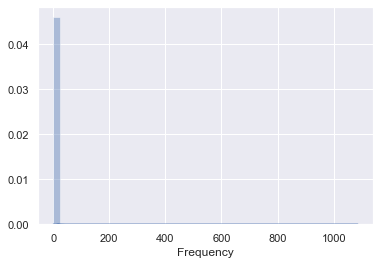

In [175]:
#Frequency distribution plot
import seaborn as sns
x = datamart['Frequency']


ax = sns.distplot(x)


In [176]:
#Descriptive Statistics (Monetary)
datamart.MonetaryValue.describe()

count    239941.000
mean       8930.659
std       24918.783
min           0.010
25%         697.370
50%        2910.000
75%        8793.840
max     4813755.940
Name: MonetaryValue, dtype: float64

on an avg ek customer 9000 rs kharch karta hai......max ek bande ne 50lac rs kharcha kiya......technniciann recommendation zaruri hai regarding aaye huey kaaam se zyaada kaam karaye......accidental gaadiyo ka recency badhaani hogi kyuki uska kharcha zyada nikaltaa.....insurance claim easy karna hoga................highway advt under toll free numbers in case of accident......24hrs service facility.............special discounts on servicing in the package if at all accident happens...............
mehengi gaadi ka parts zyada mehengaa rehtaa.............so concentrate on mehengii gaadi pe zydaa concentrate karo

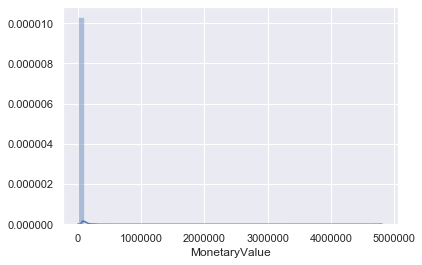

In [177]:
#Frequency distribution plot
import seaborn as sns
x = datamart['MonetaryValue']


ax = sns.distplot(x)

In [178]:
datamart.Tenure.describe()

count   239941.000
mean        89.532
std        202.757
min          1.000
25%          1.000
50%          1.000
75%         65.000
max       1644.000
Name: Tenure, dtype: float64

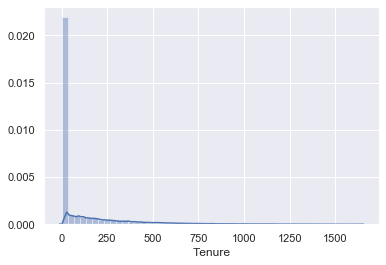

In [179]:
#Tenure distribution plot
import seaborn as sns
x = datamart['Tenure']


ax = sns.distplot(x)

In [192]:
#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data['Recency'] = datamart['Recency'].apply(np.sqrt).round(3)
Log_Tfd_Data['Frequency'] = datamart['Frequency'].apply(np.cbrt).round(3)
Log_Tfd_Data['Monetary'] = datamart['MonetaryValue'].apply(np.log).round(3)
Log_Tfd_Data['Tenure'] = datamart['Tenure'].apply(np.sqrt).round(3)

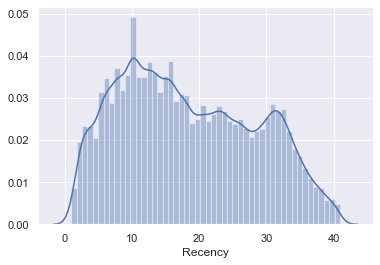

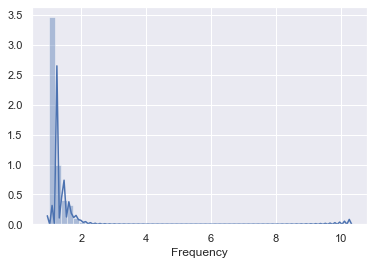

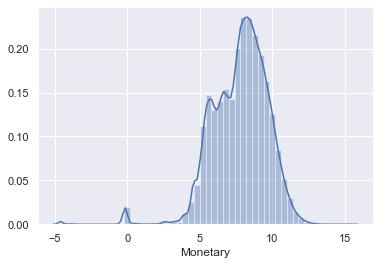

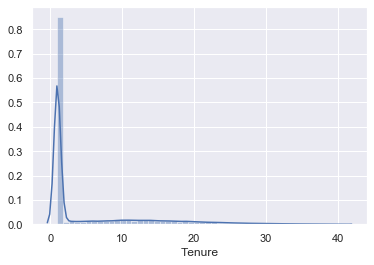

In [193]:
for i in Log_Tfd_Data.columns:
    x = Log_Tfd_Data[i]
    ax = sns.distplot(x)
    plt.show()



    

In [194]:
Log_Tfd_Data.head()

,Recency,Frequency,Monetary,Tenure
Customer No.,,,,
10,35.114,1.710,9.315,20.976
100,38.872,1.260,9.943,12.530
1000,27.368,1.817,9.084,29.732
10000,20.905,1.587,7.459,25.729
100000,23.728,1.000,8.704,1.000


In [195]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(Log_Tfd_Data)
datamart_normalized = scaler.transform(Log_Tfd_Data)

In [200]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0,n_init=100, max_iter=1000)

In [201]:
kmeans.fit(datamart_normalized)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=5, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [202]:
cluster_labels = kmeans.labels_

In [203]:
#Find the clusters for the observation given in the dataset
datamart['Cluster'] = cluster_labels
datamart.head()

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Segment,RFM_Score,General_Segment,Cluster
Customer No.,,,,,,,,,,,,
10,1233,5,11105.560,440,1,4,4,4,1444,13.000,Gold,3
100,1511,2,20799.740,157,1,4,3,4,1434,12.000,Silver,2
1000,749,6,8813.440,884,1,4,4,4,1444,13.000,Gold,3
10000,437,4,1735.520,662,2,2,4,4,2244,12.000,Silver,3
100000,563,1,6026.050,1,2,3,1,1,2311,7.000,1 time customers,0


In [204]:
datamart_rfm_k3 = datamart.assign(Cluster = cluster_labels)

In [78]:
#datamart_rfm_k2.head()

In [206]:
datamart_rfm_k3.groupby(['Cluster']).agg({
'Recency': 'mean'
,
'Frequency': 'mean'
,
'MonetaryValue': ['mean'
,
'count'],
'Tenure':'mean'}).round(0)

Recency Frequency MonetaryValue         Tenure
           mean      mean          mean  count    mean
Cluster                                               
0       921.000     1.000      4561.000  66370   5.000
1       159.000     1.000      9580.000  63796   5.000
2       428.000     3.000     14040.000  44299 223.000
3       318.000     7.000     34072.000  17330 621.000
4       187.000     1.000       343.000  48146   4.000

In [207]:
datamart['General_Segment'] = datamart.apply(segment_me, axis=1)
datamart.groupby('General_Segment').agg({
'Recency': 'mean',
'Frequency': 'mean',
'MonetaryValue': ['mean', 'count'],
'Tenure':'mean'}).round(1)

Recency Frequency MonetaryValue          Tenure
                    mean      mean          mean   count    mean
General_Segment                                                 
1 time customers 501.900     1.000      3221.400  138844   1.100
Bronze           294.700     1.300     11496.500   25359  23.400
Gold             362.900     3.500     19177.100   34200 290.900
Platinum          98.500     5.200     31205.100   17010 412.500
Silver           550.500     2.300      8861.800   24528 154.000

In [197]:
# Fit KMeans and calculate SSE for each *k*
sse = {}
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(datamart_normalized)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster cent

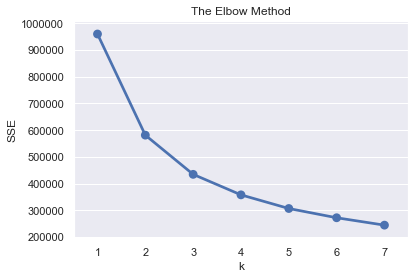

In [198]:
# Plot SSE for each *k*
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [99]:
datamart_rfm_k2 = datamart.assign(Cluster = cluster_labels)

In [100]:
datamart_rfm_k2.groupby(['Cluster']).agg({
'Recency': 'mean'
,
'Frequency': 'mean'
,
'MonetaryValue': ['mean'
,
'count'],
}).round(0)

Recency Frequency MonetaryValue        
           mean      mean          mean   count
Cluster                                        
0       321.000     4.000     25456.000   51830
1       147.000     1.000      3331.000  103831
2       865.000     1.000      5667.000   84280

In [209]:
datamart_normalized = pd.DataFrame(datamart_normalized,
index=Log_Tfd_Data.index,
columns=Log_Tfd_Data.columns)
datamart_normalized['Cluster'] = datamart_rfm_k3['Cluster']


In [210]:
datamart_normalized

,Recency,Frequency,Monetary,Tenure,Cluster
Customer No.,,,,,
10,1.679,2.141,0.814,2.005,3
100,2.056,0.403,1.146,0.917,2
1000,0.903,2.555,0.692,3.133,3
10000,0.255,1.666,-0.168,2.618,3
100000,0.538,-0.602,0.491,-0.568,0
...,...,...,...,...,...
PLX048,-1.739,-0.602,0.694,-0.568,1
PLX109,-1.309,-0.602,-0.550,-0.568,4
PLX277,-1.594,-0.602,0.560,-0.568,1


In [213]:
datamart_melt = pd.melt(datamart_normalized.reset_index(),
id_vars=['Customer No.'
,
'Cluster'],
value_vars=['Recency'
,
'Frequency'
,
'Monetary','Tenure'],
var_name='Attribute'
,
value_name='Value')

<Figure size 1080x576 with 0 Axes>

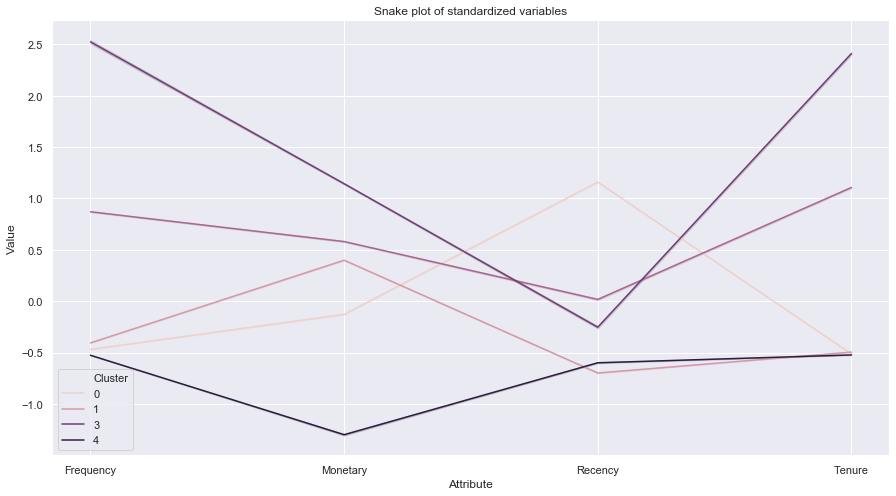

<Figure size 1080x576 with 0 Axes>

In [222]:
plt.figure(figsize = (15,8))
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute"
, y="Value"
, hue='Cluster'
, data=datamart_melt)
plt.figure(figsize = (15,8))

In [218]:
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean()
population_avg = datamart[['Recency','Frequency','MonetaryValue','Tenure']].mean()
relative_imp = cluster_avg / population_avg - 1

In [219]:
relative_imp = relative_imp[['Recency','Frequency','MonetaryValue','Tenure']]

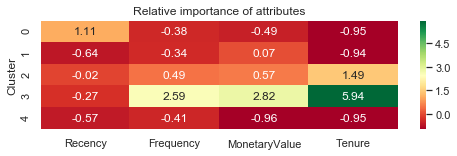

In [220]:
plt.figure(figsize=(8, 2))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f'
, cmap='RdYlGn')
plt.show()

# cluster 3: These customers are loyal to MFSC ,their frequency is also good hence revenue they give is also high but th

# cluster 2: They have been associated with MFSC  for a good period of time but the revenue generated from them is less as compared to cluster 3 which means they might not be opting for all the services at MFSC,even they have not been recent.(from marketing point of view they need to be focussed with respect to  some lucarative offers)

# cluster 0: These are our rarely visting customers,less frequent,associated with MFSC for less period of time and so revenue we get from them is lesser.( not to focus w.r.t  marketing right now)

# cluster 1 : these customers are new customers of MFSC and show good potential. they need to b converted to loyal ones

# cluster 4: has been spending less....he shud be made aware of premium servieces provided by mfsc

In [223]:
datamart

,Recency,Frequency,MonetaryValue,Tenure,R,M,F,T,RFM_Segment,RFM_Score,General_Segment,Cluster
Customer No.,,,,,,,,,,,,
10,1233,5,11105.560,440,1,4,4,4,1444,13.000,Gold,3
100,1511,2,20799.740,157,1,4,3,4,1434,12.000,Silver,2
1000,749,6,8813.440,884,1,4,4,4,1444,13.000,Gold,3
10000,437,4,1735.520,662,2,2,4,4,2244,12.000,Silver,3
100000,563,1,6026.050,1,2,3,1,1,2311,7.000,1 time customers,0
...,...,...,...,...,...,...,...,...,...,...,...,...
PLX048,1,1,8860.870,1,4,4,1,1,4411,10.000,Bronze,1
PLX109,28,1,842.930,1,4,2,1,1,4211,8.000,1 time customers,4
PLX277,6,1,6870.950,1,4,3,1,1,4311,9.000,Bronze,1


In [224]:
datamart['General_Segment'].value_counts()

1 time customers    138844
Gold                 34200
Bronze               25359
Silver               24528
Platinum             17010
Name: General_Segment, dtype: int64

In [228]:
datamart[datamart['General_Segment'] == 'Platinum']['Cluster'].value_counts()

3    8687
2    7926
1     397
Name: Cluster, dtype: int64

In [225]:
datamart[datamart['General_Segment'] == 'Gold']['Cluster'].value_counts()


2    20248
3     8260
1     5617
4       75
Name: Cluster, dtype: int64

In [226]:
datamart[datamart['General_Segment'] == 'Silver']['Cluster'].value_counts()


2    14505
1     4771
0     2876
4     1993
3      383
Name: Cluster, dtype: int64

In [227]:
datamart[datamart['General_Segment'] == 'Bronze']['Cluster'].value_counts()


1    18307
0     4371
2     1620
4     1061
Name: Cluster, dtype: int64

In [229]:
datamart[datamart['General_Segment'] == '1 time customers']['Cluster'].value_counts()

0    59123
4    45017
1    34704
Name: Cluster, dtype: int64

In [133]:
list = ['Recency','Frequency','Monetary','Tenure']

In [134]:
preds = kmeans.predict(datamart_normalized[list])
from sklearn.metrics import silhouette_score
score = silhouette_score(datamart_normalized[list], preds)
print(score)

0.31156744315648177


<Figure size 504x504 with 0 Axes>

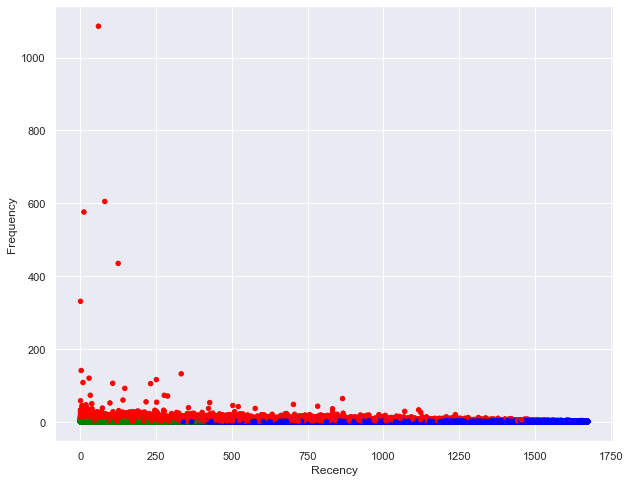

In [49]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
datamart['Color'] = datamart['Cluster'].map(lambda p: Colors[p])
ax = datamart.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = datamart['Color']
)

In [120]:
datamart

,Recency,Frequency,MonetaryValue,R,M,F,RFM_Segment,RFM_Score,General_Segment,Cluster
Customer No.,,,,,,,,,,
10,1233,5,11105.560,1,4,4,144,9.000,Silver,1
100,1511,2,20799.740,1,4,3,143,8.000,Silver,2
1000,749,6,8813.440,1,4,4,144,9.000,Silver,1
10000,437,4,1735.520,2,2,4,224,8.000,Silver,1
100000,563,1,6026.050,2,3,1,231,6.000,Bronze,2
...,...,...,...,...,...,...,...,...,...,...
PLX048,1,1,8860.870,4,4,1,441,9.000,Silver,0
PLX109,28,1,842.930,4,2,1,421,7.000,Silver,0
PLX277,6,1,6870.950,4,3,1,431,8.000,Silver,0


In [121]:
datamart.to_csv('datamart.csv')

<Figure size 504x504 with 0 Axes>

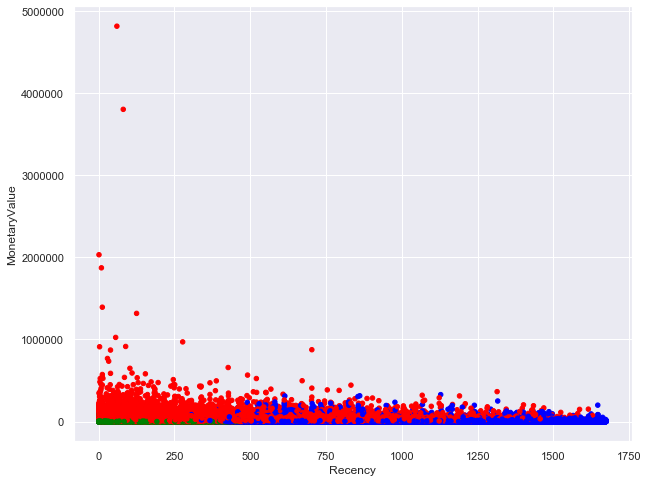

In [53]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
datamart['Color'] = datamart['Cluster'].map(lambda p: Colors[p])
ax = datamart.plot(    
    kind="scatter", 
    x="Recency", y="MonetaryValue",
    figsize=(10,8),
    c = datamart['Color']
)